In [5]:
from typing import List, Dict, Any, TypedDict

class Item(TypedDict):
    item_id: str
    city: str
    country: str
    lat: float
    lon: float
    tags: List[str]        # ex: ["museum","park","restaurant"]
    kind: str              # "poi" | "lodging" | "destination" | ...

class Dataset(TypedDict):
    items: List[Item]


In [6]:
import json

def load_dalla_seed(path:str) -> Dataset:
    raw = json.load(open(path, "r"))
    items: List[Item] = []
    for city_obj in raw:
        country = city_obj.get("country","")
        city = city_obj.get("city","")
        clat = float(city_obj.get("lat", 0.0))
        clon = float(city_obj.get("lon", 0.0))
        for poi in city_obj.get("pois", []):
            items.append({
                "item_id": f"{city}:{poi.get('name','')}",
                "city": city,
                "country": country,
                "lat": float(poi.get("lat", clat)),
                "lon": float(poi.get("lon", clon)),
                "tags": list(poi.get("categories", [])),
                "kind": "poi"
            })
    return {"items": items}


In [7]:
mini_seed = {
  "destinations":[
    {"name":"Hawaii","country":"USA","tags":["beach","surf","tropical"]},
    {"name":"Oslo","country":"Norway","tags":["cold","museum","mountain"]}
  ]
}

def load_mini_seed(obj:dict) -> Dataset:
    items = []
    for d in obj["destinations"]:
        items.append({
            "item_id": d["name"],
            "city": d["name"],
            "country": d.get("country",""),
            "lat": 0.0, "lon": 0.0,
            "tags": d.get("tags",[]),
            "kind": "destination"
        })
    return {"items": items}


In [8]:
DIM_TAGS = [
  # culture / musée / patrimoine
  "entertainment.museum","heritage","tourism.attraction","tourism.sights",
  # nature & outdoor
  "leisure.park","mountain","beach","tropical",
  # food & cafés
  "catering.restaurant","catering.cafe","vegetarian","vegan",
  # religion / monuments
  "religion.place_of_worship","building.historic","man_made.tower",
  # shopping
  "commercial.shopping_mall",
  # accessibilité
  "wheelchair.yes","internet_access.free",
  # climat (tags maison)
  "cold","warm"
]

import numpy as np

def vectorize_tags(tags:list[str]) -> np.ndarray:
    v = np.zeros(len(DIM_TAGS), dtype=np.float32)
    s = set(tags)
    for i, t in enumerate(DIM_TAGS):
        if t in s:
            v[i] = 1.0
    # normalisation (optionnelle ici)
    n = np.linalg.norm(v)
    return v if n==0 else v/n


In [13]:
def build_matrix(dataset: Dataset):
    X = []
    meta = []
    for it in dataset["items"]:
        v = vectorize_tags(it["tags"])
        X.append(v)
        meta.append(it)
    return np.vstack(X), meta   # X: (N, D), meta: liste des items
def cosine_sim(a: np.ndarray, B: np.ndarray) -> np.ndarray:
    # a: (D,), B: (N,D)
    # suppose a et B sont déjà normalisés
    return B @ a

def recommend(user_vec: np.ndarray, X: np.ndarray, meta: list[Item], k=10):
    sims = cosine_sim(user_vec, X)  # (N,)
    idx = np.argsort(-sims)[:k]
    return [(meta[i], float(sims[i])) for i in idx]


In [14]:
user_tags = ["beach","catering.restaurant","leisure.park"]
u = vectorize_tags(user_tags)


In [15]:
# 1) Avec Dalla
ds_dalla = load_dalla_seed("cities_geocoded_pois.json")  # adapter Dalla
X_dalla, meta_dalla = build_matrix(ds_dalla)
recos_dalla = recommend(u, X_dalla, meta_dalla, k=10)
for it, score in recos_dalla:
    print(f"{it['city']} – {it['item_id']}  score={score:.3f}")

# 2) Avec mini seed maison (indépendant du format)
ds_mini = load_mini_seed(mini_seed)                      # adapter maison
X_mini, meta_mini = build_matrix(ds_mini)
recos_mini = recommend(u, X_mini, meta_mini, k=5)
for it, score in recos_mini:
    print(f"{it['city']}  score={score:.3f}")


Viseu – Viseu:Cidade de Viseu  score=0.577
Viseu – Viseu:Parreira do Minho  score=0.577
Viseu – Viseu:Congolesa  score=0.577
Viseu – Viseu:Italian Indian Palace  score=0.577
Viseu – Viseu:Parque infantil  score=0.577
Paris – Paris:Le Grand Véfour  score=0.577
Paris – Paris:Le Dôme  score=0.577
Paris – Paris:Bouillon Racine  score=0.577
Turin – Turin:Pizze & Delizie  score=0.577
Turin – Turin:Dù Cesari  score=0.577
Hawaii  score=0.408
Oslo  score=0.000


In [16]:
import pandas as pd

def summarize_by_city(recos):
    df = pd.DataFrame([
        {"city": it["city"], "name": it["item_id"], "score": score}
        for it, score in recos
    ])
    df_summary = (df.groupby("city")["score"]
                    .mean()
                    .reset_index()
                    .sort_values("score", ascending=False))
    return df_summary

summary = summarize_by_city(recos_dalla)
print(summary.head(10))


    city    score
0  Paris  0.57735
1  Turin  0.57735
2  Viseu  0.57735


In [17]:
from IPython.display import display, HTML

def display_recos_table(df):
    html = df.head(10).style \
        .bar(subset=["score"], color='#5fba7d') \
        .format({"score": "{:.3f}"}) \
        .set_caption("Top recommandations par ville") \
        .hide(axis="index")
    display(html)

display_recos_table(summary)


city,score
Paris,0.577
Turin,0.577
Viseu,0.577


In [18]:
from collections import Counter

def summarize_city_tags(recos, topn=3):
    rows = []
    for it, score in recos:
        rows.append({"city": it["city"], "tags": it["tags"], "score": score})
    df = pd.DataFrame(rows)
    top_tags = (
        df.explode("tags")
          .groupby("city")["tags"]
          .apply(lambda x: [t for t, _ in Counter(x).most_common(topn)])
    )
    df_summary = df.groupby("city")["score"].mean().reset_index()
    df_summary["top_tags"] = df_summary["city"].map(top_tags)
    return df_summary.sort_values("score", ascending=False)

df_summary = summarize_city_tags(recos_dalla)
display_recos_table(df_summary)


city,score,top_tags
Paris,0.577,"['catering', 'catering.restaurant', 'catering.restaurant.french']"
Turin,0.577,"['catering', 'catering.restaurant', 'catering.restaurant.pizza']"
Viseu,0.577,"['catering', 'catering.restaurant', 'leisure']"


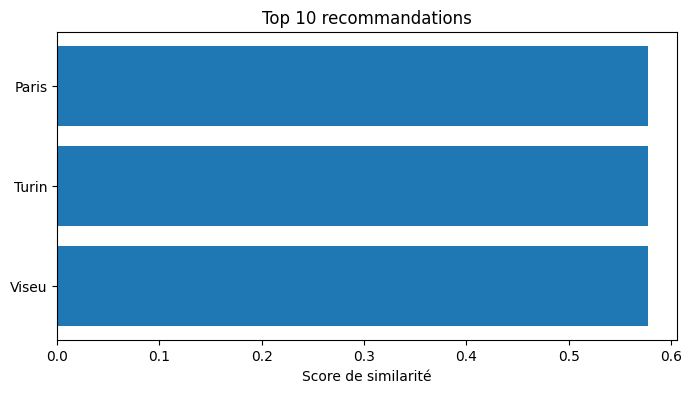

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(df_summary["city"].head(10), df_summary["score"].head(10))
plt.gca().invert_yaxis()
plt.xlabel("Score de similarité")
plt.title("Top 10 recommandations")
plt.show()
